<a href="https://colab.research.google.com/github/Rachhh53/Company-Bankrupcy-Prediction-Kaggle/blob/main/CompanyBankruptcyPred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Ingest

In [75]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
# import SVC classifier
from sklearn.svm import SVC
# import metrics to compute accuracy
from sklearn.metrics import accuracy_score, precision_score, classification_report, confusion_matrix, roc_curve, roc_auc_score, make_scorer

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Import dataset
df = pd.read_csv('https://raw.githubusercontent.com/Rachhh53/Company-Bankrupcy-Prediction-Kaggle/main/data.csv')
df.head()

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,0.780985,1.256969e-04,0.0,0.458143,0.000725,0.0,0.147950,0.147950,0.147950,0.169141,0.311664,0.017560,0.095921,0.138736,0.022102,0.848195,0.688979,0.688979,0.217535,4.980000e+09,0.000327,0.263100,0.363725,0.002259,0.001208,0.629951,0.021266,0.207576,0.792424,0.005024,...,0.190643,0.004094,0.001997,1.473360e-04,0.147308,0.334015,0.276920,0.001036,0.676269,0.721275,0.339077,0.025592,0.903225,0.002022,0.064856,7.010000e+08,6.550000e+09,0.593831,4.580000e+08,0.671568,0.424206,0.676269,0.339077,0.126549,0.637555,0.458609,0.520382,0.312905,0.118250,0,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,0.781506,2.897851e-04,0.0,0.461867,0.000647,0.0,0.182251,0.182251,0.182251,0.208944,0.318137,0.021144,0.093722,0.169918,0.022080,0.848088,0.689693,0.689702,0.217620,6.110000e+09,0.000443,0.264516,0.376709,0.006016,0.004039,0.635172,0.012502,0.171176,0.828824,0.005059,...,0.182419,0.014948,0.004136,1.383910e-03,0.056963,0.341106,0.289642,0.005210,0.308589,0.731975,0.329740,0.023947,0.931065,0.002226,0.025516,1.065198e-04,7.700000e+09,0.593916,2.490000e+09,0.671570,0.468828,0.308589,0.329740,0.120916,0.641100,0.459001,0.567101,0.314163,0.047775,0,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,0.780284,2.361297e-04,25500000.0,0.458521,0.000790,0.0,0.177911,0.177911,0.193713,0.180581,0.307102,0.005944,0.092338,0.142803,0.022760,0.848094,0.689463,0.689470,0.217601,7.280000e+09,0.000396,0.264184,0.368913,0.011543,0.005348,0.629631,0.021248,0.207516,0.792484,0.005100,..

In [3]:
df.shape

(6819, 96)

There are 6819 observations and 96 features in this dataset.

# EDA

## What data types do we have?

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

In [5]:
df.isnull().sum()

Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64

No missing values! Yay

Check for leading spaces in the column names:

In [6]:
col_names = df.columns

col_names

Index(['Bankrupt?', ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operating Profit

There are leading spaces (spaces at the start of the string name) in the dataframe. So, I will remove these leading spaces.


In [7]:
# remove leading spaces from column names
df.columns = df.columns.str.strip()
# confirm they're removed
df.columns

Index(['Bankrupt?', 'ROA(C) before interest and depreciation before interest',
       'ROA(A) before interest and % after tax',
       'ROA(B) before interest and depreciation after tax',
       'Operating Gross Margin', 'Realized Sales Gross Margin',
       'Operating Profit Rate', 'Pre-tax net Interest Rate',
       'After-tax net Interest Rate',
       'Non-industry income and expenditure/revenue',
       'Continuous interest rate (after tax)', 'Operating Expense Rate',
       'Research and development expense rate', 'Cash flow rate',
       'Interest-bearing debt interest rate', 'Tax rate (A)',
       'Net Value Per Share (B)', 'Net Value Per Share (A)',
       'Net Value Per Share (C)', 'Persistent EPS in the Last Four Seasons',
       'Cash Flow Per Share', 'Revenue Per Share (Yuan ¥)',
       'Operating Profit Per Share (Yuan ¥)',
       'Per Share Net profit before tax (Yuan ¥)',
       'Realized Sales Gross Profit Growth Rate',
       'Operating Profit Growth Rate', 'After-tax

## Review feature distributions

In [8]:
# target variable distribution
df['Bankrupt?'].value_counts()

0    6599
1     220
Name: Bankrupt?, dtype: int64

In [9]:
# percentage distribution of dependent variable
df['Bankrupt?'].value_counts()/np.float(len(df))

0    0.967737
1    0.032263
Name: Bankrupt?, dtype: float64

The percentage of observations that are labelled with class 0 and 1 are 96.8% and 3.2% so this is a very imbalanced dataset.

## Check for outliers

In [10]:
round(df.describe(),2)

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6.819000e+03,6.819000e+03,6819.00,6.819000e+03,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6.819000e+03,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6.819000e+03,6.819000e+03,6819.00,6819.00,6.819000e+03,6.819000e+03,6819.00,6.819000e+03,6819.00,6819.00,6819.00,...,6819.00,6819.00,6.819000e+03,6.819000e+03,6819.00,6819.00,6819.00,6.819000e+03,6819.00,6819.00,6819.00,6.819000e+03,6819.00,6819.00,6819.00,6.819000e+03,6.819000e+03,6819.00,6.819000e+03,6819.00,6.819000e+03,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6.819000e+03,6819.00,6819.00,6819.00,6819.00,6819.00,6819.00,6819.0,6819.00
mean,0.03,0.51,0.56,0.55,0.61,0.61,1.00,0.80,0.81,0.30,0.78,1.995347e+09,1.950427e+09,0.47,1.644801e+07,0.12,0.19,0.19,0.19,0.23,0.32,1.328641e+06,0.11,0.18,0.02,0.85,0.69,0.69,0.22,5.508097e+09,1.566212e+06,0.26,0.38,4.032850e+05,8.376595e+06,0.63,4.416337e+06,0.11,0.89,0.01,...,0.52,0.12,3.592902e+06,3.715999e+07,0.09,0.35,0.28,5.580680e+07,0.76,0.74,0.33,5.416004e+07,0.93,0.00,0.03,1.195856e+09,2.163735e+09,0.59,2.471977e+09,0.67,1.220120e+06,0.76,0.33,0.12,0.65,0.46,0.59,0.32,0.03,0.00,0.81,1.862942e+07,0.62,0.61,0.84,0.28,0.03,0.57,1.0,0.05
std,0.18,0.06,0.07,0.06,0.02,0.02,0.01,0.01,0.01,0.01,0.01,3.237684e+09,2.598292e+09,0.02,1.082750e+08,0.14,0.03,0.03,0.03,0.03,0.02,5.170709e+07,0.03,0.03,0.01,0.01,0.01,0.01,0.01,2.897718e+09,1.141594e+08,0.01,0.02,3.330216e+07,2.446847e+08,0.01,1.684069e+08,0.05,0.05,0.03,...,0.22,0.14,1.716209e+08,5.103509e+08,0.05,0.04,0.01,5.820516e+08,0.21,0.01,0.01,5.702706e+08,0.03,0.01,0.03,2.821161e+09,3.374944e+09,0.01,2.938623e+09,0.01,1.007542e+08,0.21,0.01,0.02,0.05,0.03,0.06,0.01,0.03,0.03,0.04,3.764501e+

Draw boxplots to visualize outliers:

In [11]:
def get_boxplots(feat):
    plt.figure()
    return sns.boxplot(x=df[feat])

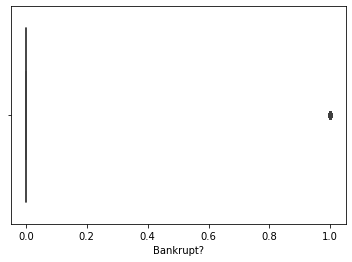

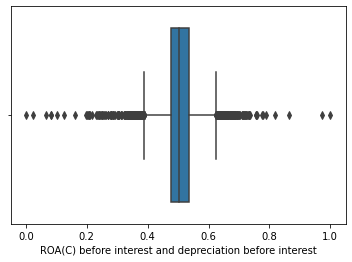

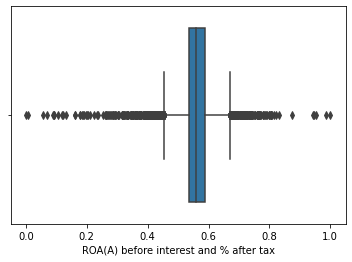

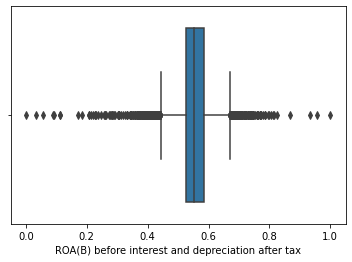

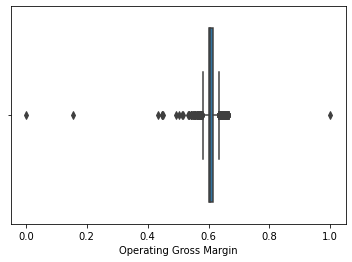

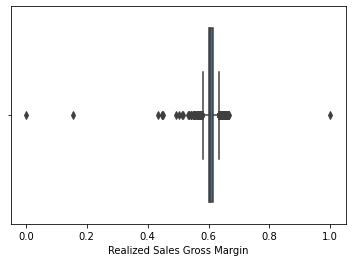

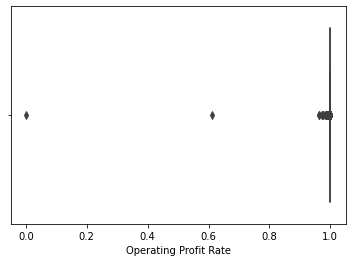

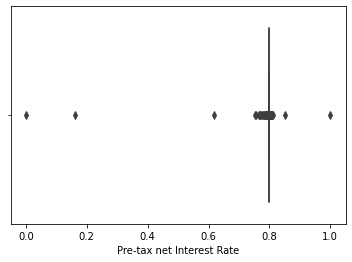

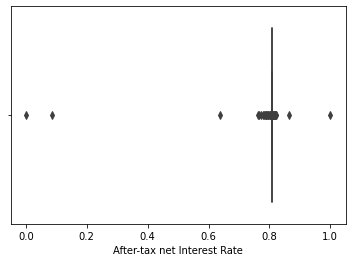

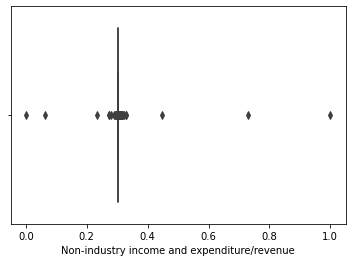

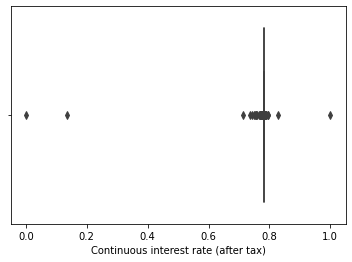

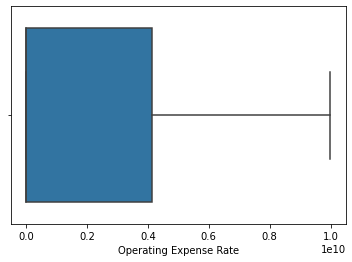

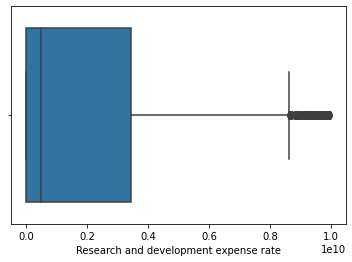

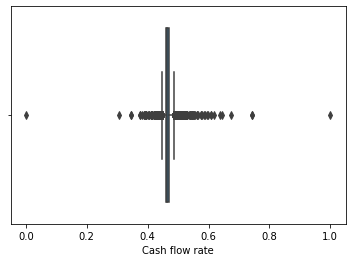

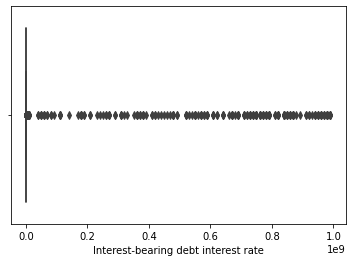

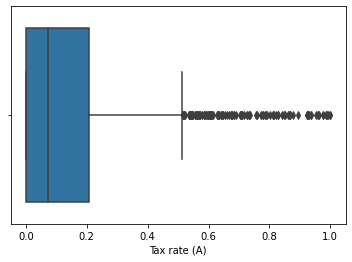

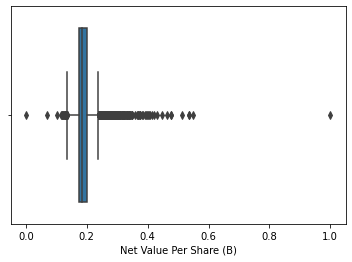

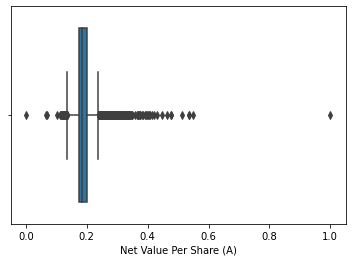

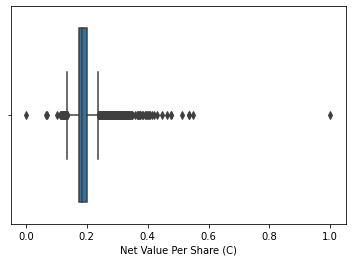

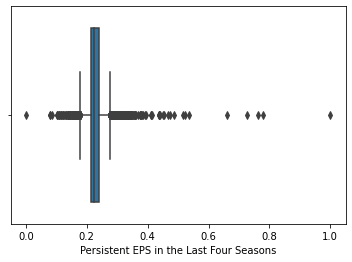

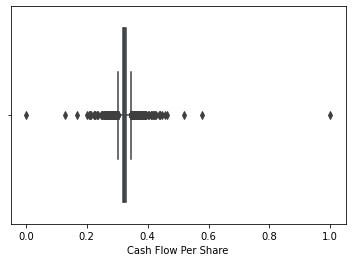

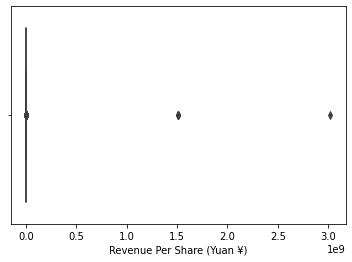

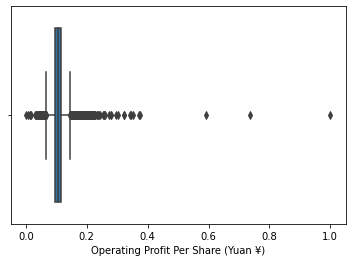

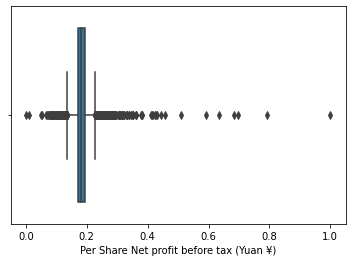

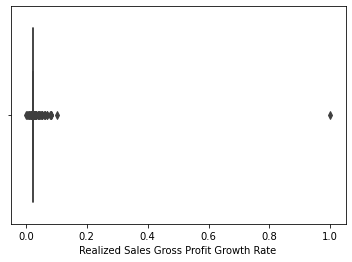

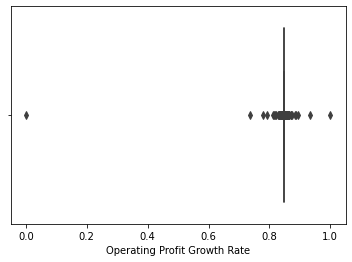

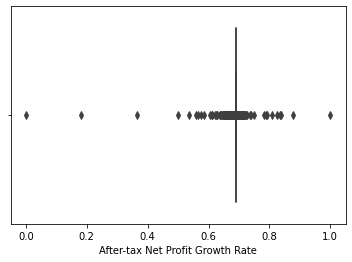

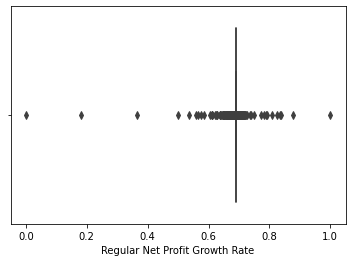

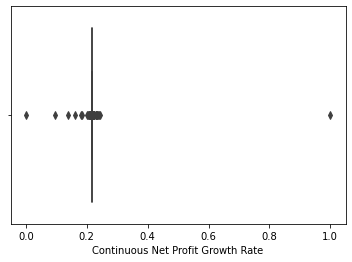

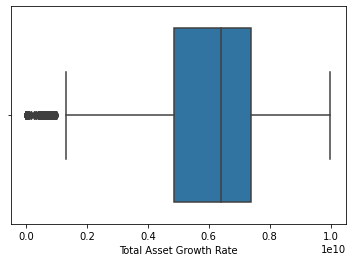

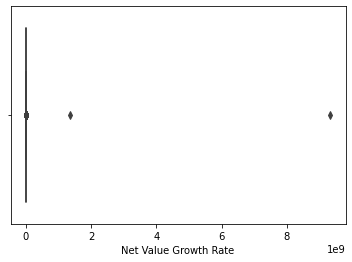

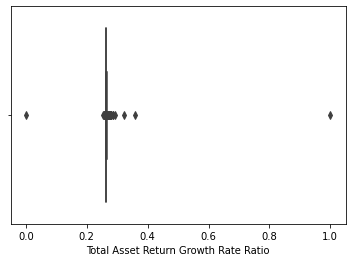

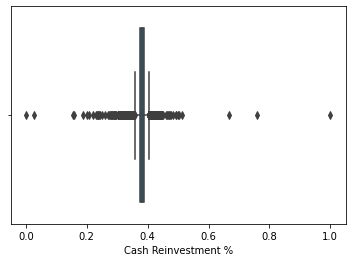

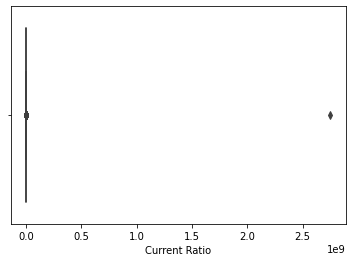

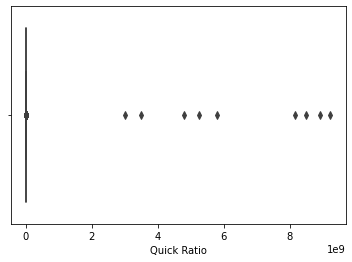

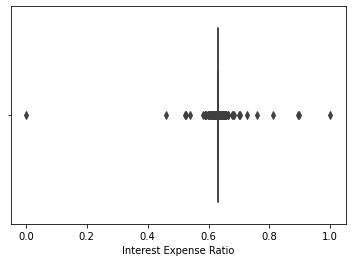

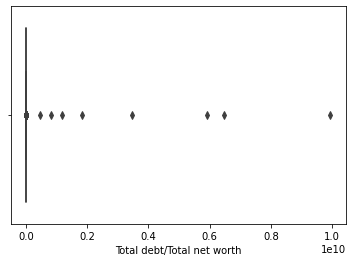

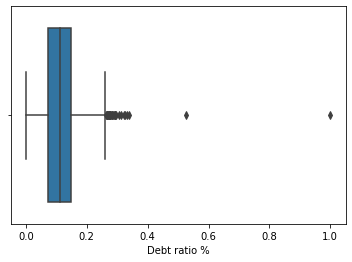

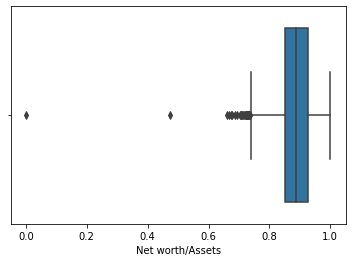

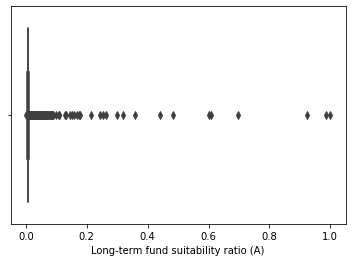

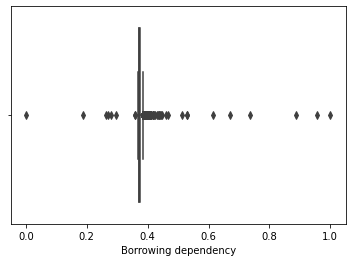

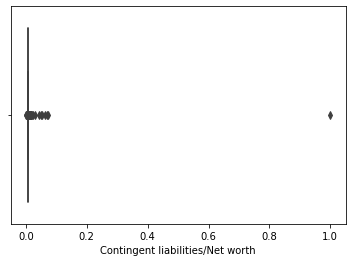

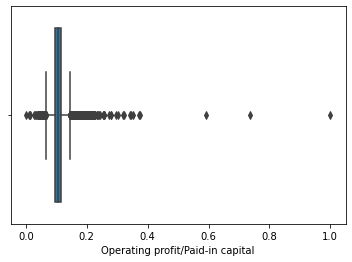

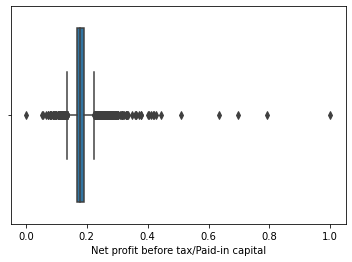

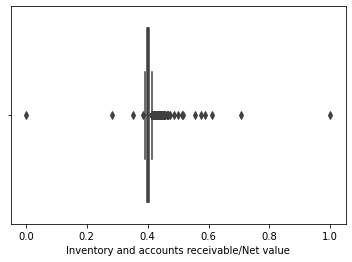

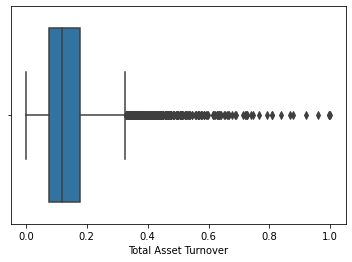

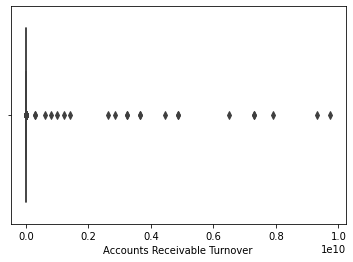

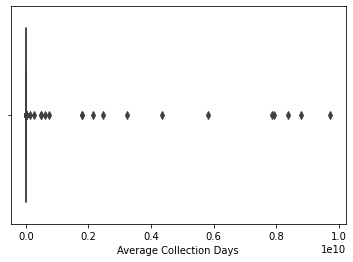

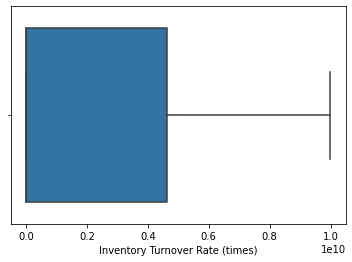

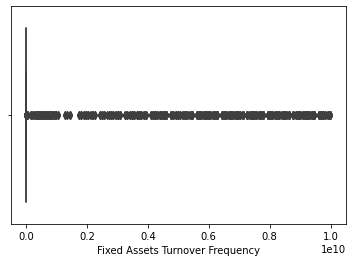

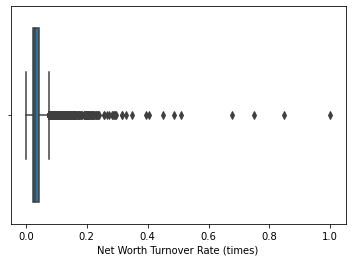

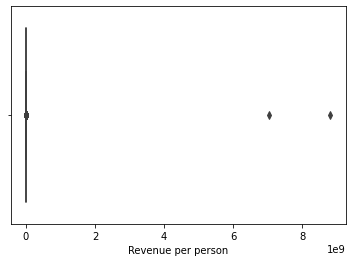

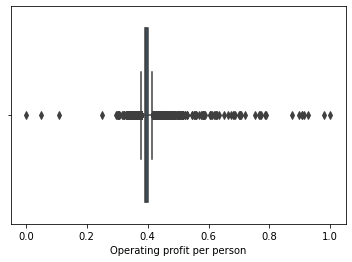

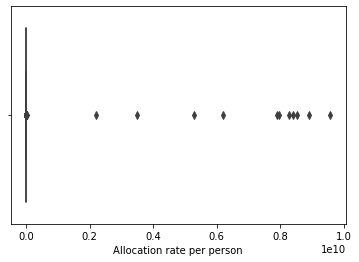

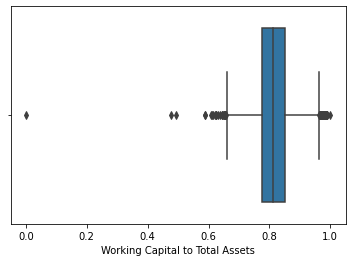

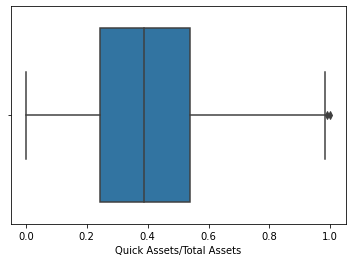

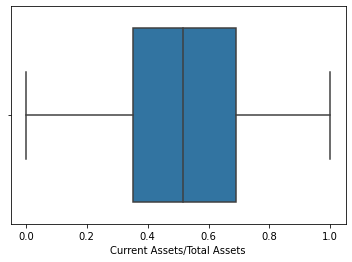

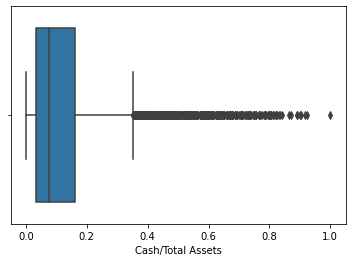

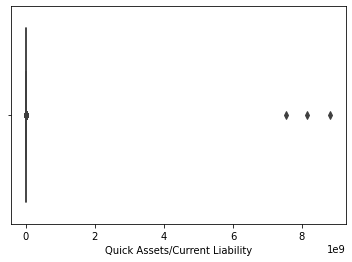

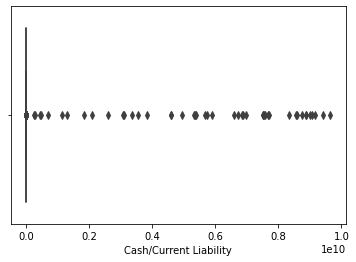

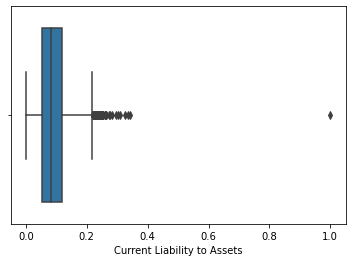

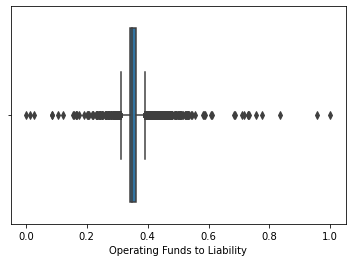

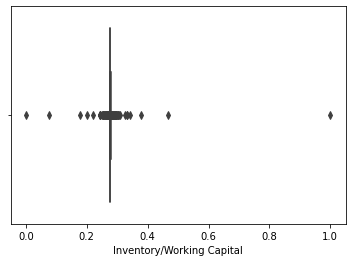

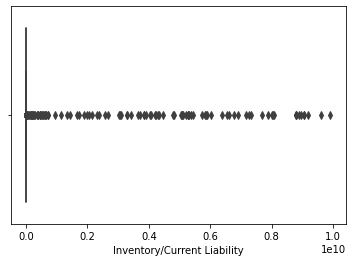

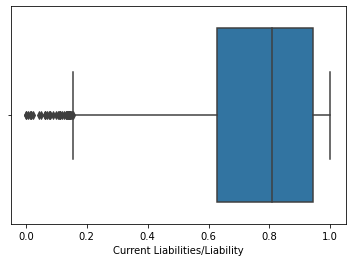

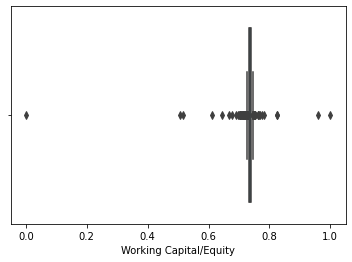

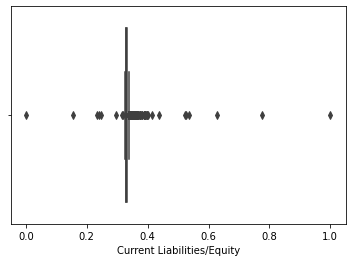

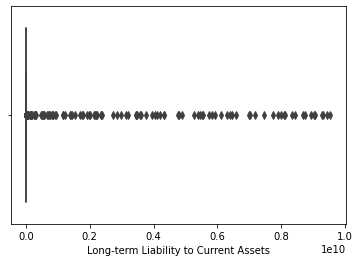

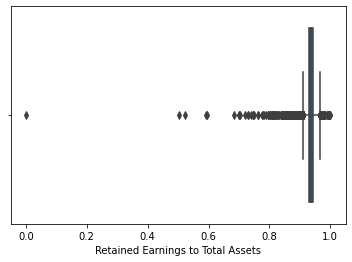

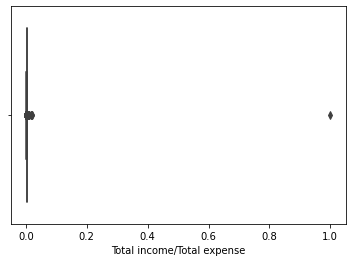

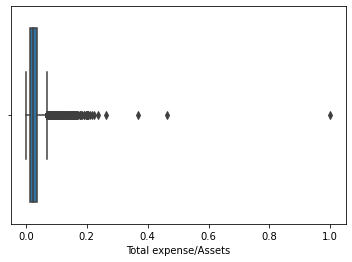

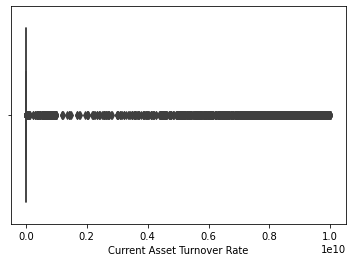

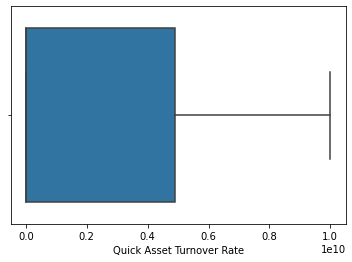

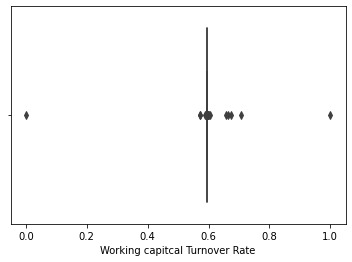

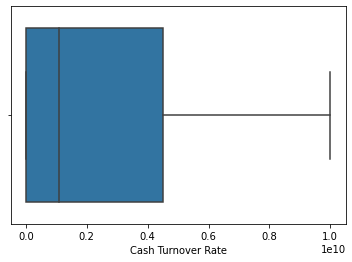

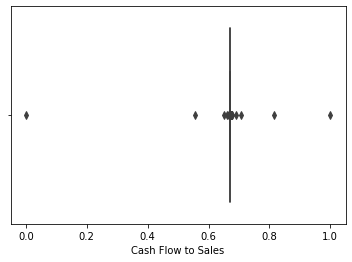

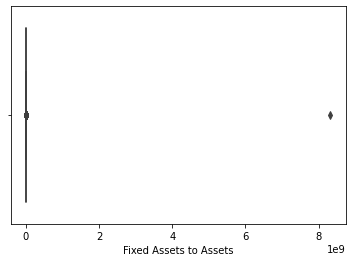

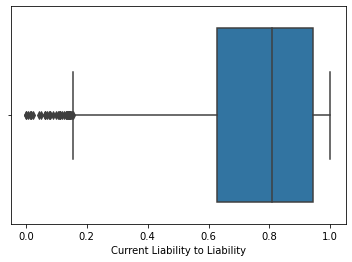

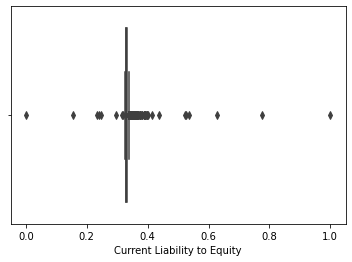

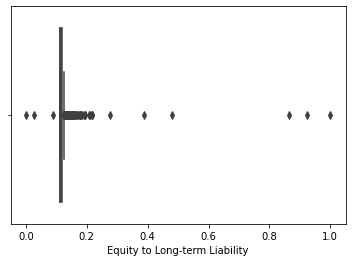

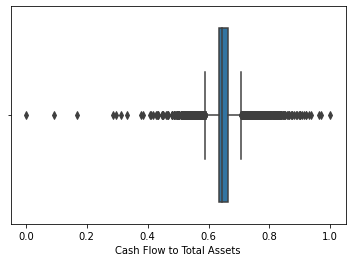

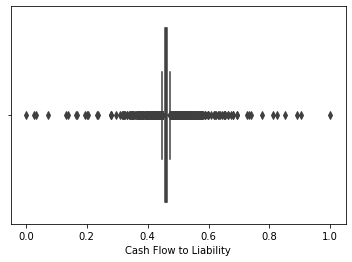

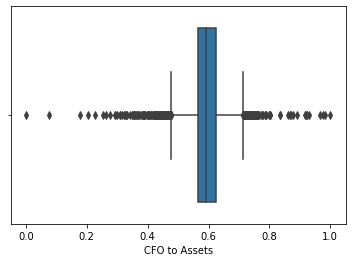

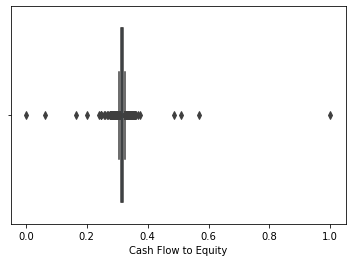

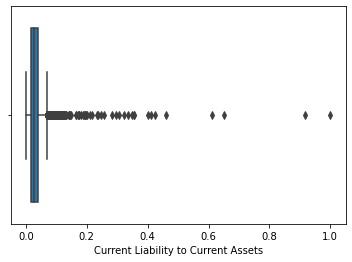

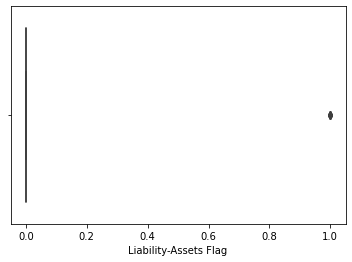

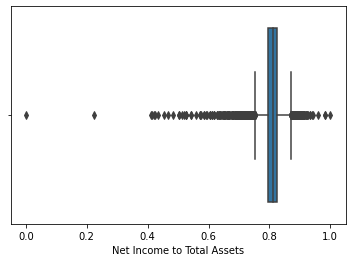

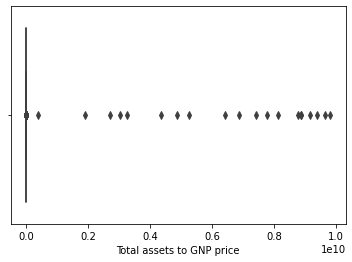

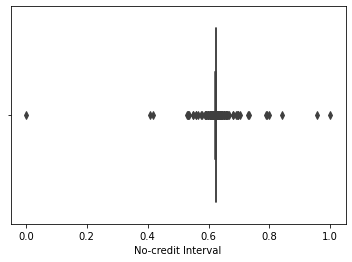

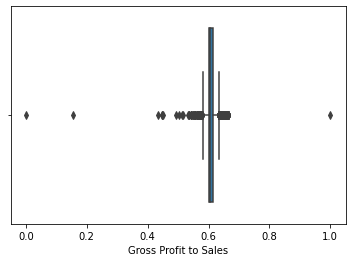

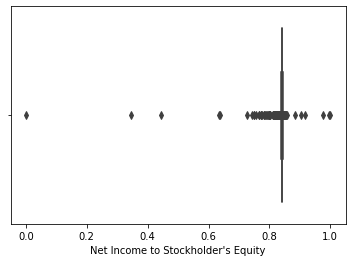

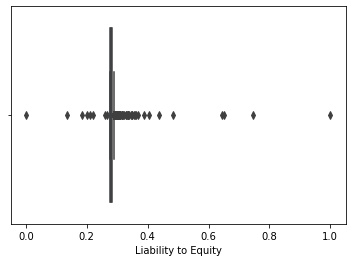

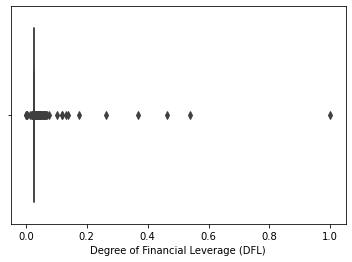

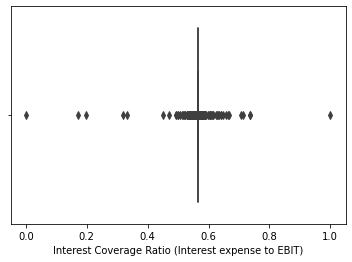

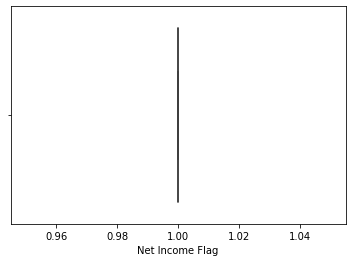

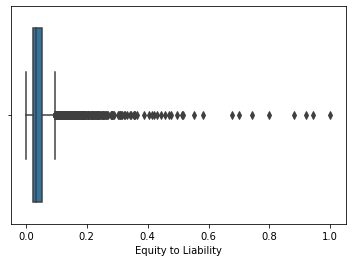

In [12]:
# boxplots to identify outliers
for (colName, colData) in df.iteritems():
    get_boxplots(colName)

These boxplots show that there are a lot of outliers in our data.

In [13]:
def plot_hist(variable):
    plt.figure(figsize=(7,3))
    plt.hist(df[variable],bins=30)
    plt.xlabel(variable)
    plt.title("{}".format(variable))
    plt.show()

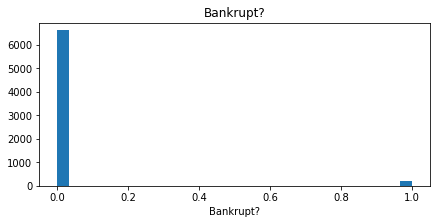

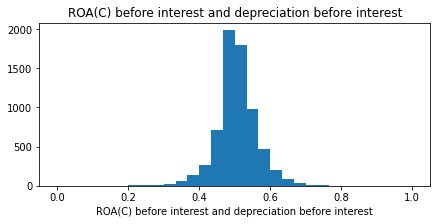

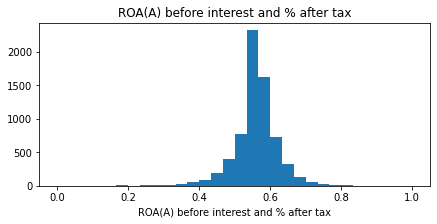

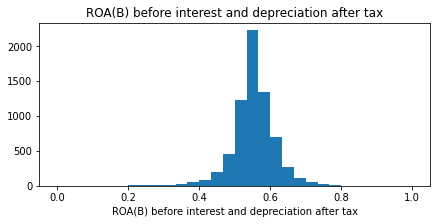

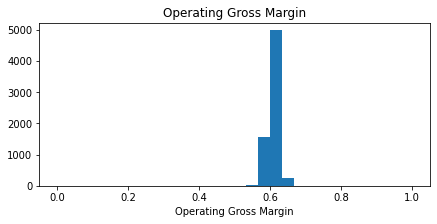

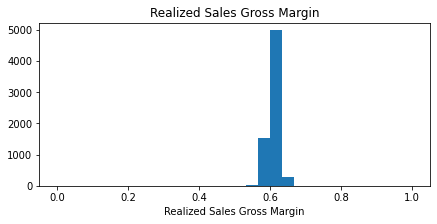

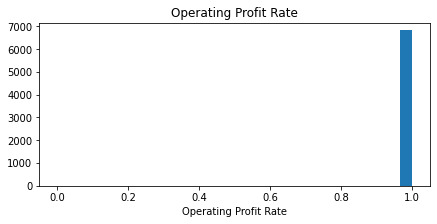

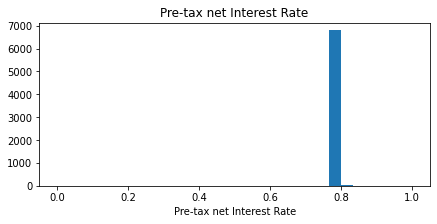

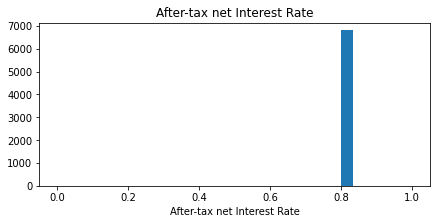

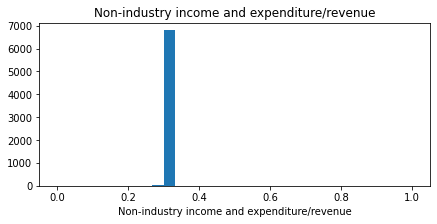

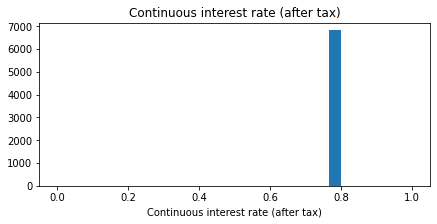

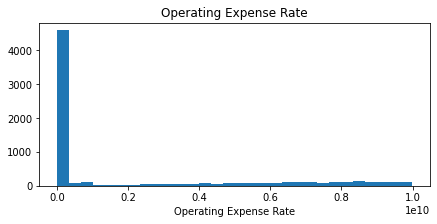

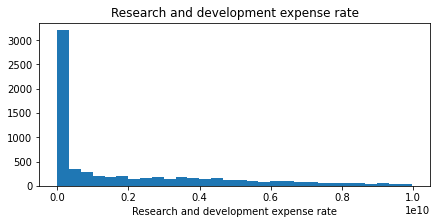

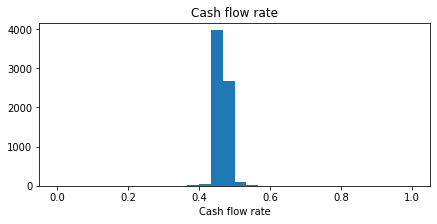

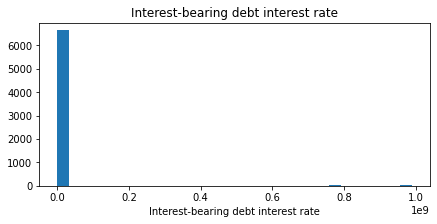

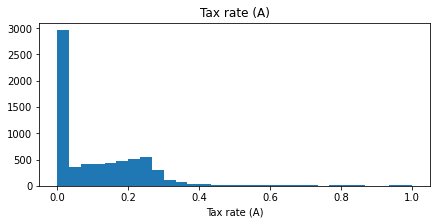

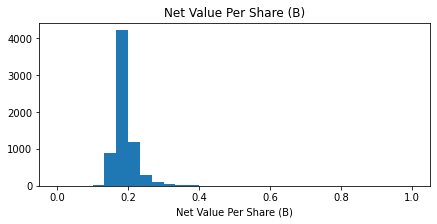

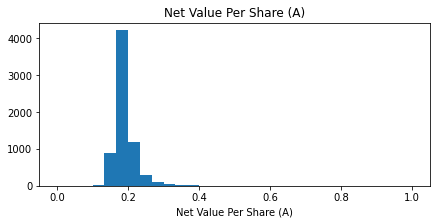

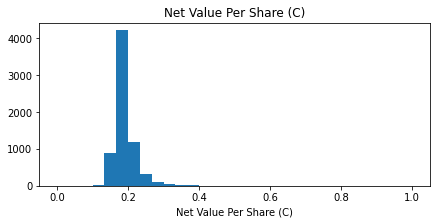

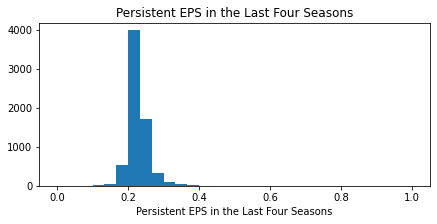

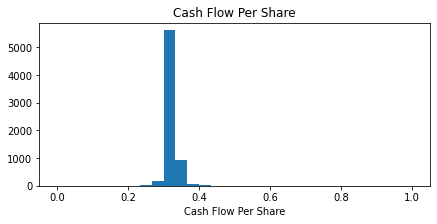

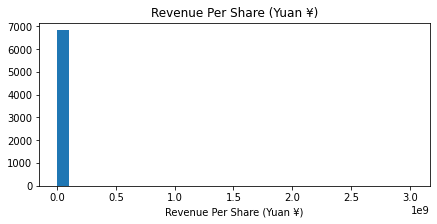

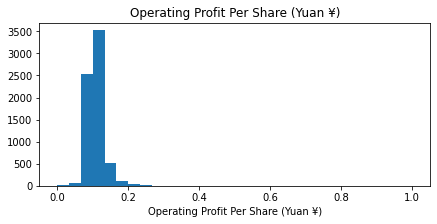

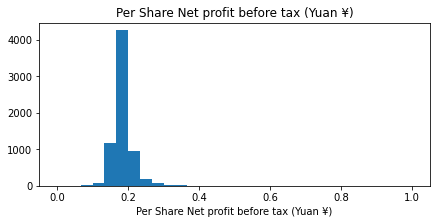

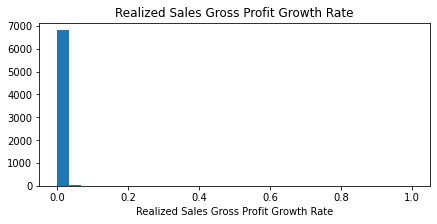

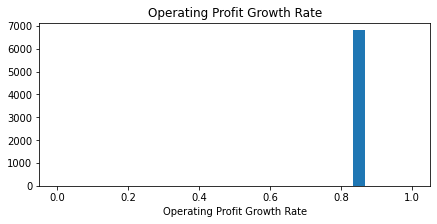

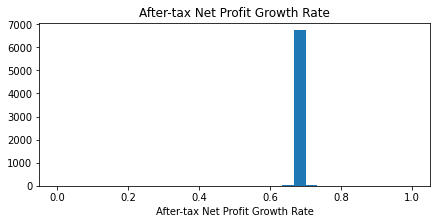

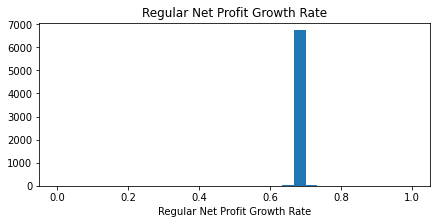

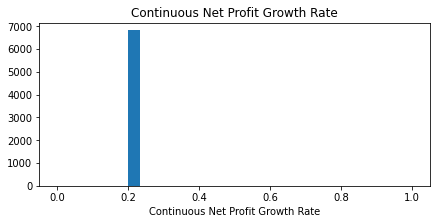

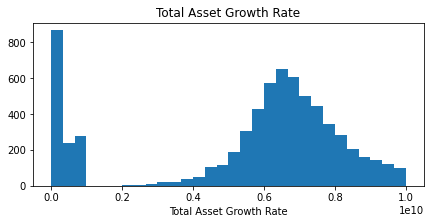

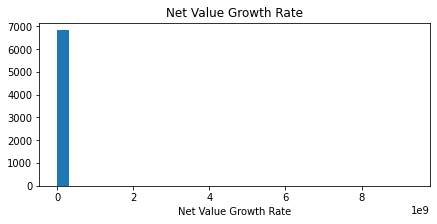

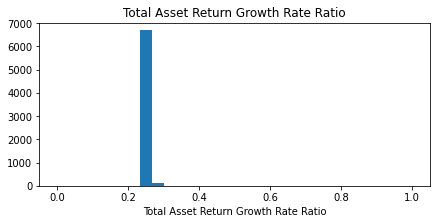

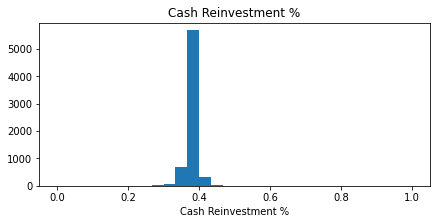

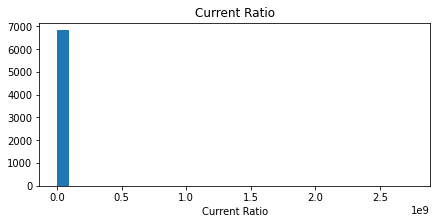

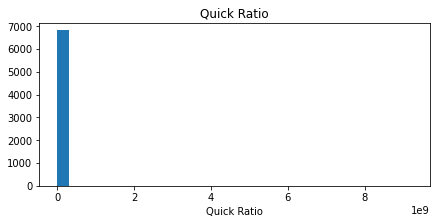

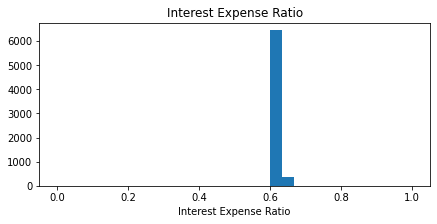

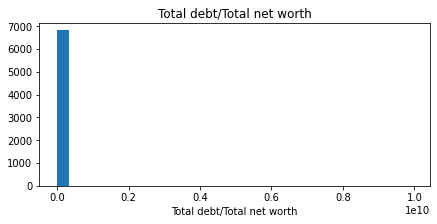

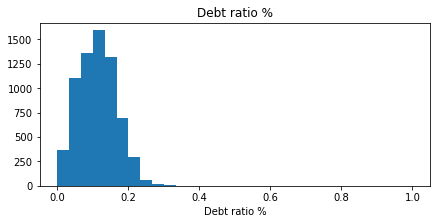

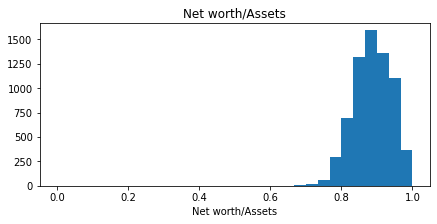

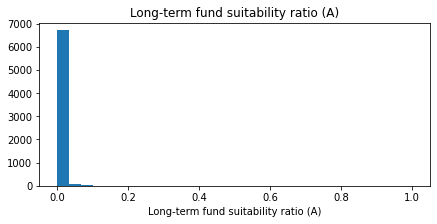

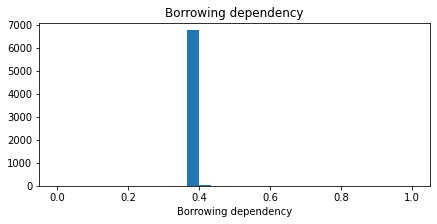

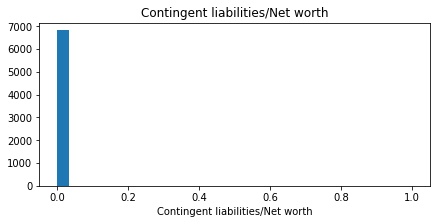

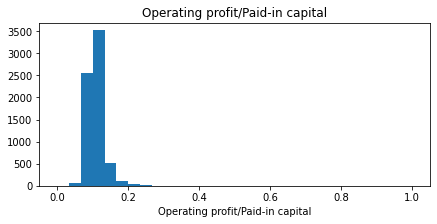

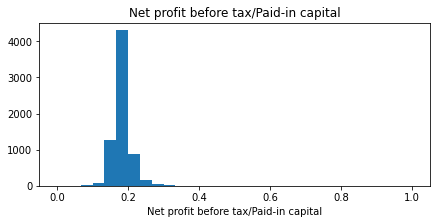

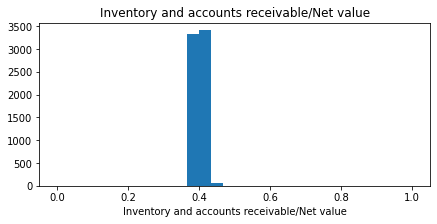

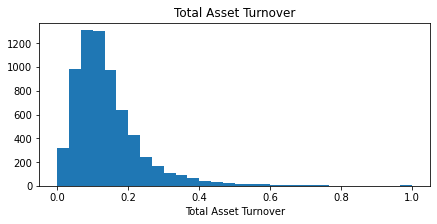

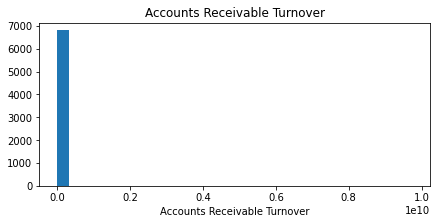

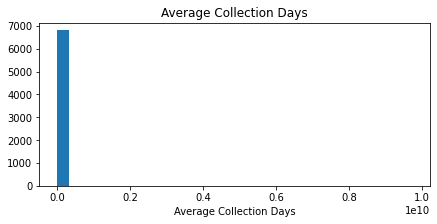

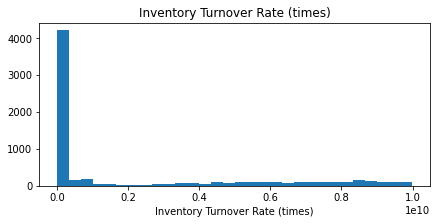

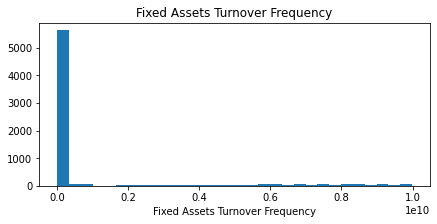

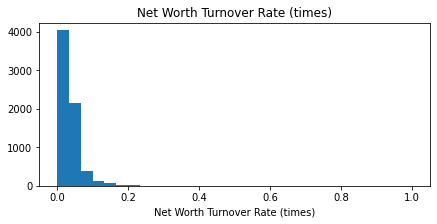

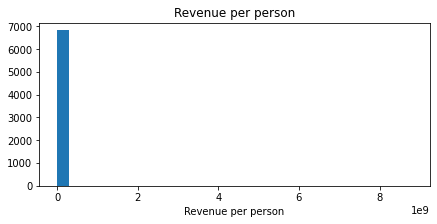

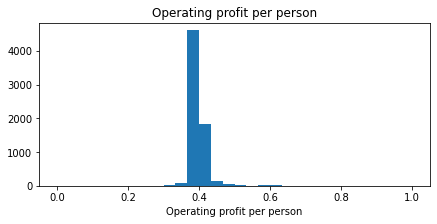

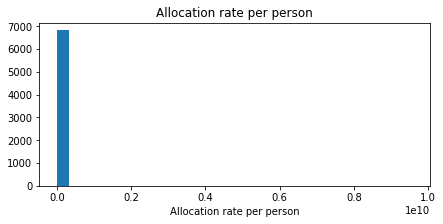

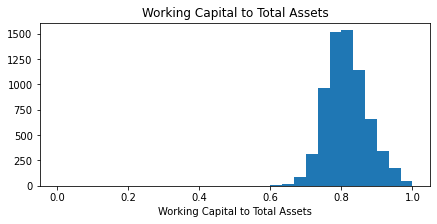

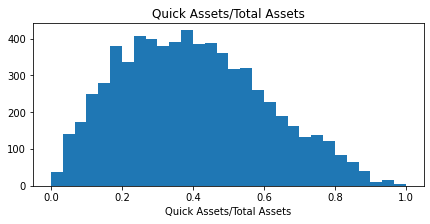

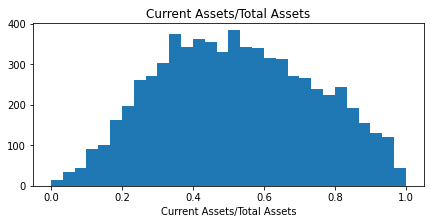

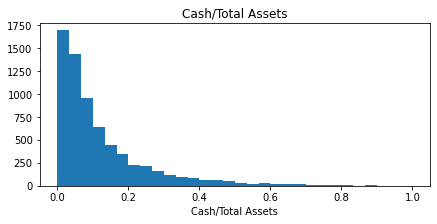

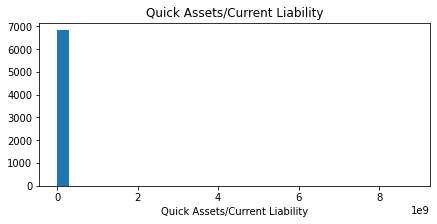

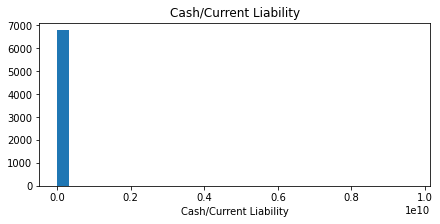

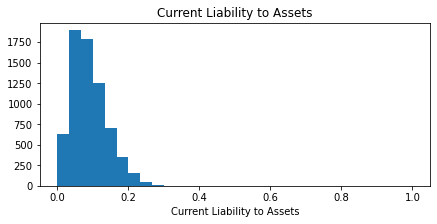

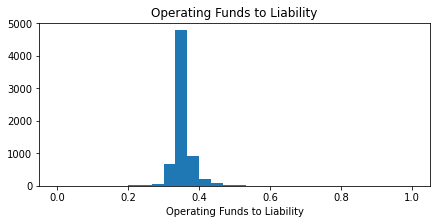

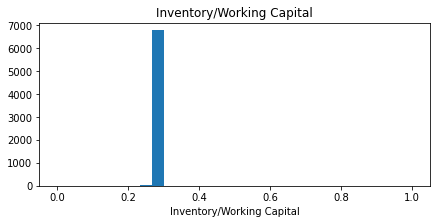

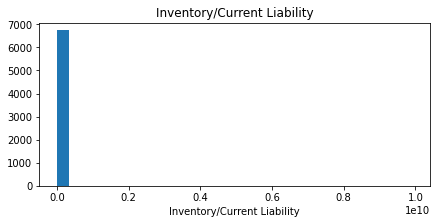

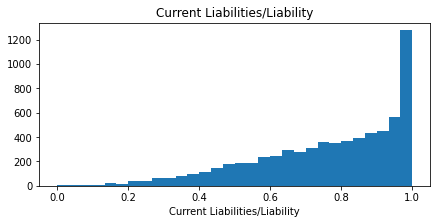

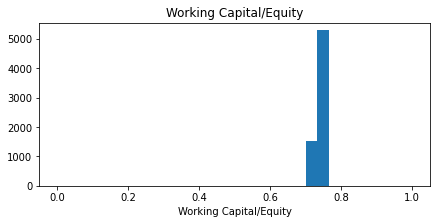

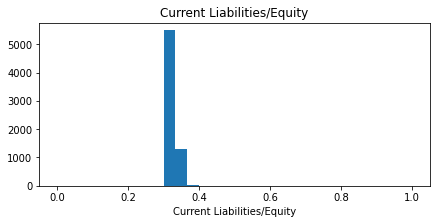

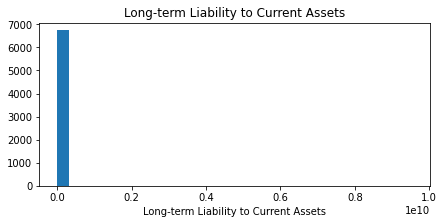

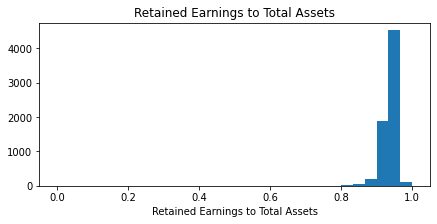

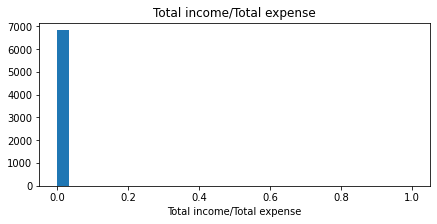

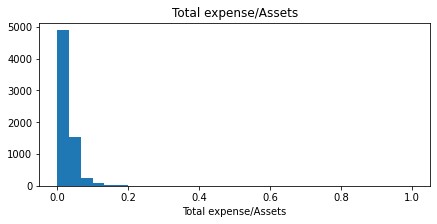

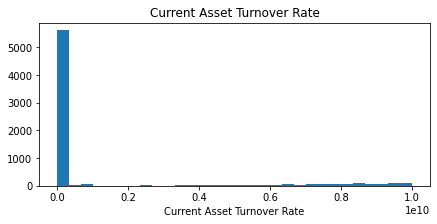

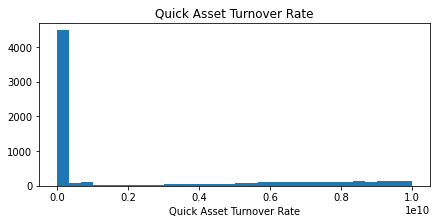

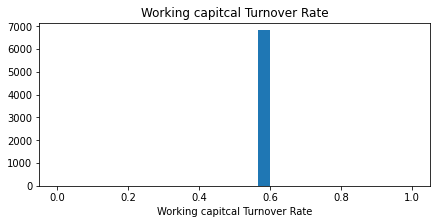

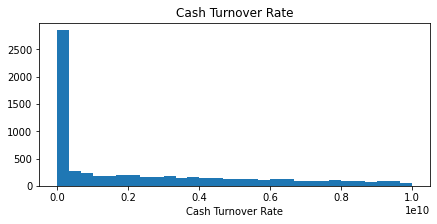

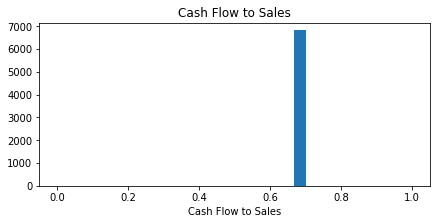

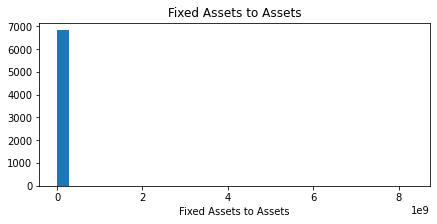

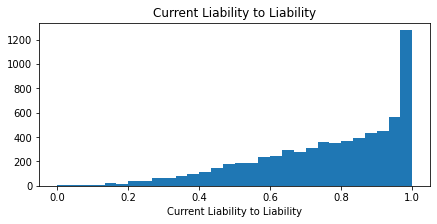

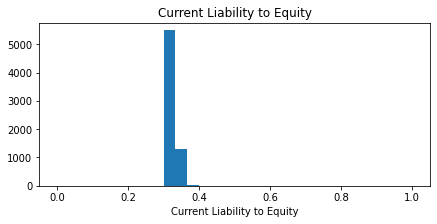

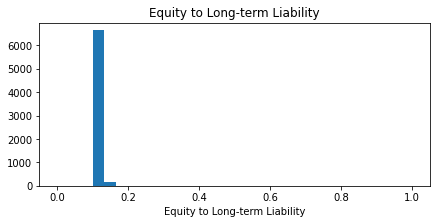

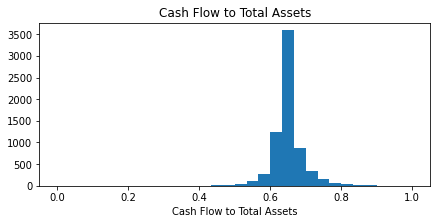

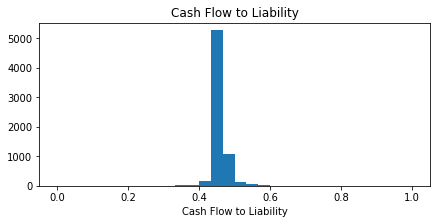

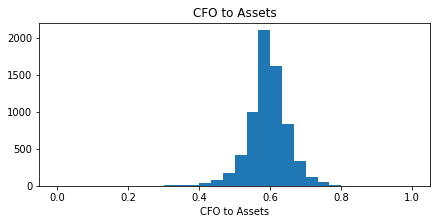

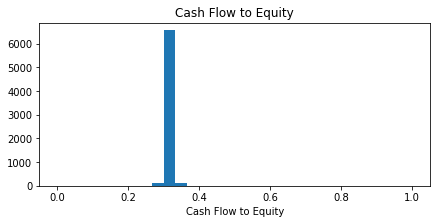

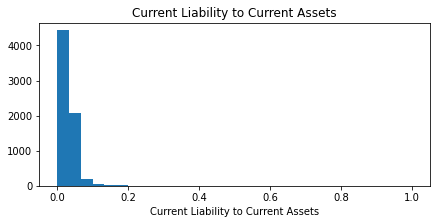

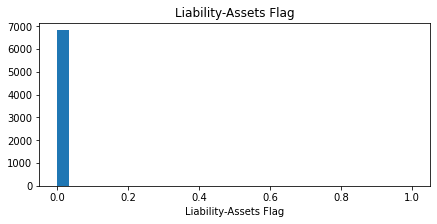

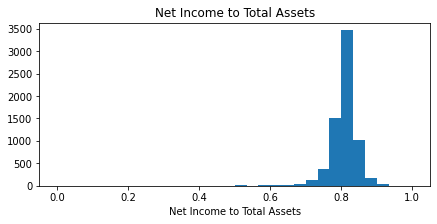

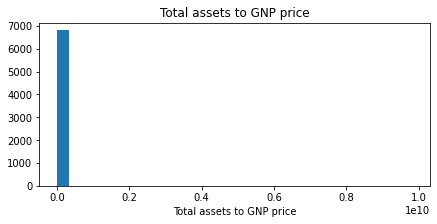

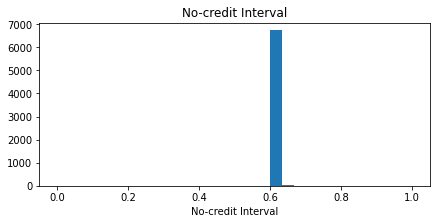

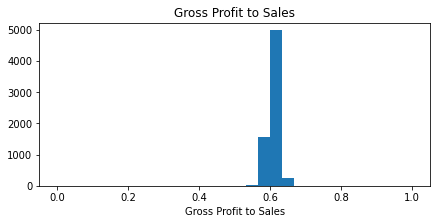

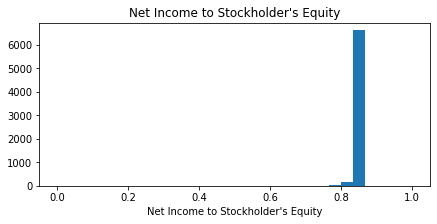

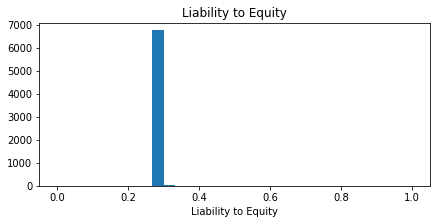

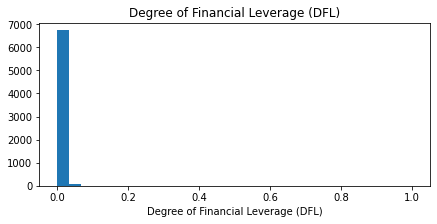

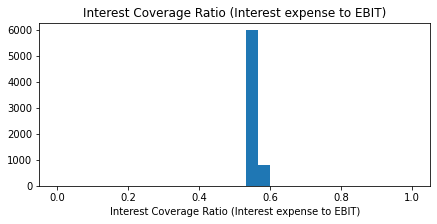

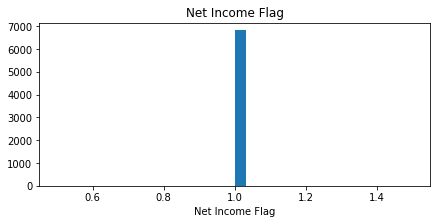

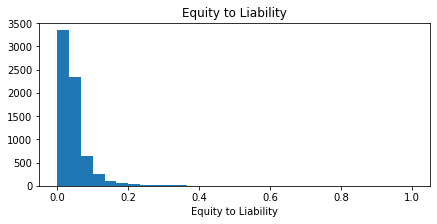

In [14]:
for (colName, colData) in df.iteritems():
    plot_hist(colName)

Many of our variables are skewed.

## Split the training set

Split the training set into an 80% training and 20% validation set and conduct / improve upon previous EDA

In [15]:
X = df.drop(['Bankrupt?'], axis=1)
y = df['Bankrupt?']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
X_train.shape, X_test.shape

((5455, 95), (1364, 95))

## Feature Scaling

In [17]:
cols = X_train.columns
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [18]:
X_train = pd.DataFrame(X_train, columns=[cols])

In [19]:
X_test = pd.DataFrame(X_test, columns=[cols])

In [20]:
X_train.describe()

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),Operating Expense Rate,Research and development expense rate,Cash flow rate,Interest-bearing debt interest rate,Tax rate (A),Net Value Per Share (B),Net Value Per Share (A),Net Value Per Share (C),Persistent EPS in the Last Four Seasons,Cash Flow Per Share,Revenue Per Share (Yuan ¥),Operating Profit Per Share (Yuan ¥),Per Share Net profit before tax (Yuan ¥),Realized Sales Gross Profit Growth Rate,Operating Profit Growth Rate,After-tax Net Profit Growth Rate,Regular Net Profit Growth Rate,Continuous Net Profit Growth Rate,Total Asset Growth Rate,Net Value Growth Rate,Total Asset Return Growth Rate Ratio,Cash Reinvestment %,Current Ratio,Quick Ratio,Interest Expense Ratio,Total debt/Total net worth,Debt ratio %,Net worth/Assets,Long-term fund suitability ratio (A),Borrowing dependency,...,Current Assets/Total Assets,Cash/Total Assets,Quick Assets/Current Liability,Cash/Current Liability,Current Liability to Assets,Operating Funds to Liability,Inventory/Working Capital,Inventory/Current Liability,Current Liabilities/Liability,Working Capital/Equity,Current Liabilities/Equity,Long-term Liability to Current Assets,Retained Earnings to Total Assets,Total income/Total expense,Total expense/Assets,Current Asset Turnover Rate,Quick Asset Turnover Rate,Working capitcal Turnover Rate,Cash Turnover Rate,Cash Flow to Sales,Fixed Assets to Assets,Current Liability to Liability,Current Liability to Equity,Equity to Long-term Liability,Cash Flow to Total Assets,Cash Flow to Liability,CFO to Assets,Cash Flow to Equity,Current Liability to Current Assets,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
count,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,...,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5.455000e+03,5455.0,5.455000e+03
mean,9.982035e-16,-2.070245e-16,-2.775252e-16,1.757139e-15,1.006334e-15,7.508917e-15,-8.683713e-15,6.484337e-15,-1.687369e-15,1.408360e-16,1.465372e-17,1.371751e-17,2.367187e-15,2.310505e-17,1.012735e-16,-9.012873e-16,-7.836880e-17,-5.407186e-17,-3.858610e-16,-2.122755e-17,-2.056037e-17,8.744075e-16,4.768973e-16,7.142640e-17,-6.773047e-15,4.722406e-15,2.380724e-15,-2.875500e-15,1.098215e-16,-1.200346e-17,-2.864803e-16,-1.449324e-15,-1.934495e-17,-8.999574e-18,-1.909853e-15,3.903843e-18,1.993110e-16,9.016110e-18,-2.404381e-17,-3.508447e-16,...,-1.037361e-16,3.873060e-17,1.633788e-17,1.900150e-17,4.906962e-17,-6.061655e-16,-2.036595e-15,-2.067549e-17,-1.232337e-16,5.682189e-15,-4.031611e-15,-2.128733e-16,-1.116695e-15,1.114548e-17,1.1918

Ready for logistic regression!

# Modeling

## SVM

Reference: https://www.kaggle.com/prashant111/svm-classifier-tutorial

### Default hyperparameters

In [21]:
# instantiate classifier with default hyperparameters
svc=SVC()
# fit classifier to training set
svc.fit(X_train,y_train)
# make predictions on test set
y_pred=svc.predict(X_test)
# compute and print accuracy score
#print('Model accuracy score with default hyperparameters: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
#print('Model precision score with default hyperparameters: {0:0.4f}'. format(precision_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1318
           1       1.00      0.02      0.04        46

    accuracy                           0.97      1364
   macro avg       0.98      0.51      0.51      1364
weighted avg       0.97      0.97      0.95      1364



**Accuracy = # of correct predictions / # of total predictions**<br>
>As stated above, our classes are very imbalanced, so accuracy is not a very good measure for this model. It seems this model might be classifying everyone as 0 (not bankrupt) because our imbalance of the original dataset was class 0 and 1 are 96.8% and 3.2% which are very close to the 97% accuracy score.


**Precision = # of true positives / (# of true positives + # of false positivies)**
> Within everything that has been predicted as positive, what percentage is corect? <br>
The model has high precision for both classes. It is correctly finding all the positives for Bankrupt?=1 but is misclassifying 3% of the Bankrupt?=1.



**Recall = # of true positives / (# of true positves + # of false negatives)**
> Within everything that is actually positive, how many did the model succeed in finding?
<br>
Again, these numbers are suspiciously close to the class imbalance. The model is succeeding in finding all the positive cases in the data for Bankrupt?=0 and only 2% of the Bankrupt?=1.


**F1 Score = 2 * ( (precision * recall) / (precision + recall) )\
Combines precision and recall (both rates) into a single, weighted metric**
> Since this value is a reflection of both precision and recall, these averages are obvious. The macro avg represents (.98 + .04) / 2, which the weighted average heavily favors the 1 class because our dataset is 97% 1s. This is still a better measure than most of the others, if we had to choose only one. Luckiliy, we don't.



Reference: https://towardsdatascience.com/the-f1-score-bec2bbc38aa6

#### Confusion Matrix

Confusion matrix

 [[1318    0]
 [  45    1]]

True Positives(TP) =  1318

True Negatives(TN) =  1

False Positives(FP) =  0

False Negatives(FN) =  45


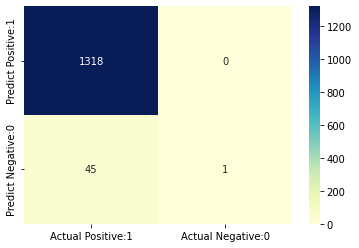

In [22]:
# Print the Confusion Matrix and slice it into four pieces
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

The confusion matrix shows us 1318 + 1 = 1319 correct predictions and 45 incorrect predictions.

#### ROC

ROC curve help us to choose a threshold level that balances sensitivity and specificity for a particular context.

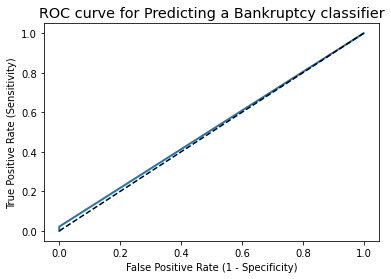

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a Bankruptcy classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC AUC

In [24]:
ROC_AUC = roc_auc_score(y_test, y_pred)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.5109


This model is not much better than a coin flip.

In [25]:
Cross_validated_ROC_AUC = cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc').mean()
print('Cross validated ROC AUC : {:.4f}'.format(Cross_validated_ROC_AUC))

Cross validated ROC AUC : 0.8557


#### GridSerachCV



### C=100.0



We have seen that there are outliers in our dataset. So, we should increase the value of C as higher C means fewer outliers. So, I will run SVM with kernel=rbf and C=100.0.


In [26]:
# instantiate classifier with rbf kernel and C=100
svc=SVC(C=100.0)
# fit classifier to training set
svc.fit(X_train,y_train)
# make predictions on test set
y_pred=svc.predict(X_test)
# compute and print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1318
           1       0.32      0.24      0.28        46

    accuracy                           0.96      1364
   macro avg       0.65      0.61      0.63      1364
weighted avg       0.95      0.96      0.95      1364



Increasing the C value lowered the accuracy score and precision of predicting Bankruptcy, but increased the recall of predicting Bankruptcy.<br>
Precision-recall trade-off is at play here, where we have increased our recall of class 1 at the expense of lowering our precision.<br>
The F1 scores of the overall model here are better. with weight avg F1 remains unchanged while macro avg has increased a good amount, indicating this model may be performing better overall.

#### Confusion Matrix

Confusion matrix

 [[1295   23]
 [  35   11]]

True Positives(TP) =  1295

True Negatives(TN) =  11

False Positives(FP) =  23

False Negatives(FN) =  35


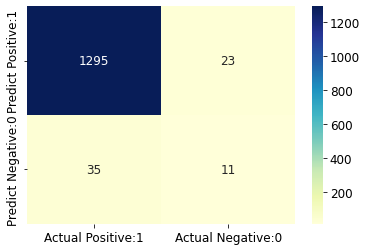

In [27]:
# Print the Confusion Matrix and slice it into four pieces
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

The confusion matrix shows us 1295 + 11 = 1306 correct predictions and 23 + 35 = 58 incorrect predictions.

#### ROC

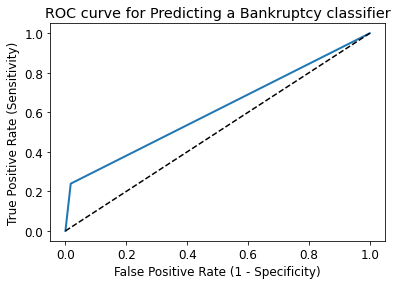

In [28]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a Bankruptcy classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC AUC

In [29]:
ROC_AUC = roc_auc_score(y_test, y_pred)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.6108


This model is performing better than the last model with default hyperparameters.

In [30]:
Cross_validated_ROC_AUC = cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc').mean()
print('Cross validated ROC AUC : {:.4f}'.format(Cross_validated_ROC_AUC))

Cross validated ROC AUC : 0.8739


and with better cross validation.

#### Check overfitting/underfitting



---


Since this model is performing the best of all my SVMs so far, I want to compare the training and testing data to check for overfitting.

In [31]:
y_pred_train = svc.predict(X_train)
y_pred_train

array([0, 0, 0, ..., 0, 0, 0])

In [32]:
# compute and print classification report
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5281
           1       1.00      0.90      0.95       174

    accuracy                           1.00      5455
   macro avg       1.00      0.95      0.97      5455
weighted avg       1.00      1.00      1.00      5455



Looks like our model is making pretty accurate and precise predictions!

In [33]:
# check for overfitting and underfitting
# average accuracy
print('Training set score: {:.4f}'.format(svc.score(X_train, y_train)))
print('Test set score: {:.4f}'.format(svc.score(X_test, y_test)))

Training set score: 0.9969
Test set score: 0.9575


Training set accuracy is 99.7% and test set accuracy is 95.8%. This model is probably overfitting...

#### Model accuracy vs null accuracy

In [34]:
# check class distribution in test set
y_test.value_counts()

0    1318
1      46
Name: Bankrupt?, dtype: int64

In [35]:
# check null accuracy score
null_accuracy = (1318/(1318+46))
print('Null accuracy score: {0:0.4f}'. format(null_accuracy))

Null accuracy score: 0.9663


Model accuracy = 95.8%<br>
Null accuracy = 96.6%<br>
So our model isn't doing any better than null accuracy, which is always predicting the most frequent class.

### C=1000.0

In [36]:
# instantiate classifier with rbf kernel and C=1000
svc=SVC(C=1000.0) 
# fit classifier to training set
svc.fit(X_train,y_train)
# make predictions on test set
y_pred=svc.predict(X_test)
# compute and print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1318
           1       0.27      0.22      0.24        46

    accuracy                           0.95      1364
   macro avg       0.62      0.60      0.61      1364
weighted avg       0.95      0.95      0.95      1364



This change didn't get us anywhere.

#### Confusion Matrix

Confusion matrix

 [[1291   27]
 [  36   10]]

True Positives(TP) =  1291

True Negatives(TN) =  10

False Positives(FP) =  27

False Negatives(FN) =  36


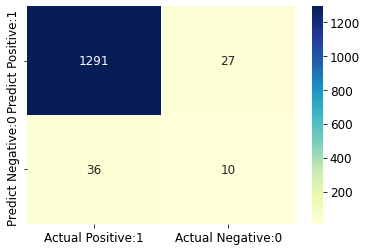

In [37]:
# Print the Confusion Matrix and slice it into four pieces
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

The confusion matrix shows 1291 + 10 = 1301 correct predictions and 27 + 36 = 63 incorrect predictions.

#### ROC

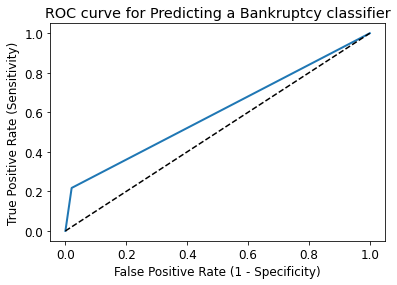

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a Bankruptcy classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC AUC

In [39]:
ROC_AUC = roc_auc_score(y_test, y_pred)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.5985


In [40]:
Cross_validated_ROC_AUC = cross_val_score(svc, X_train, y_train, cv=10, scoring='roc_auc').mean()
print('Cross validated ROC AUC : {:.4f}'.format(Cross_validated_ROC_AUC))

Cross validated ROC AUC : 0.8386


### Linear Kernel and C=1.0

In [41]:
# instantiate classifier with linear kernel and C=1.0
linear_svc=SVC(kernel='linear', C=1.0)
# fit classifier to training set
linear_svc.fit(X_train,y_train)
# make predictions on test set
y_pred_test=linear_svc.predict(X_test)
# compute and print classification report
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1318
           1       0.57      0.09      0.15        46

    accuracy                           0.97      1364
   macro avg       0.77      0.54      0.57      1364
weighted avg       0.96      0.97      0.96      1364



#### Confusion Matrix

Confusion matrix

 [[1315    3]
 [  42    4]]

True Positives(TP) =  1315

True Negatives(TN) =  4

False Positives(FP) =  3

False Negatives(FN) =  42


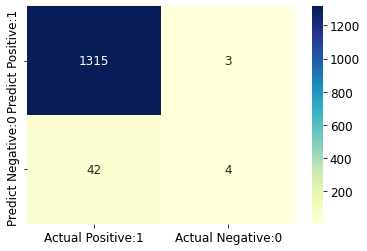

In [42]:
# Print the Confusion Matrix and slice it into four pieces
cm = confusion_matrix(y_test, y_pred_test)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

The confusion matrix shows 1315 + 4 = 1319 correct predictions and 3 + 42 = 45 incorrect predictions.

#### ROC

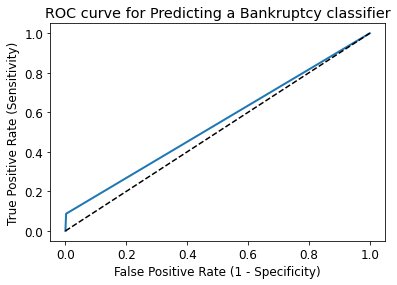

In [43]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a Bankruptcy classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC AUC

In [44]:
ROC_AUC = roc_auc_score(y_test, y_pred_test)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.5423


This model is not much better than a coin flip.

In [45]:
Cross_validated_ROC_AUC = cross_val_score(linear_svc, X_train, y_train, cv=10, scoring='roc_auc').mean()
print('Cross validated ROC AUC : {:.4f}'.format(Cross_validated_ROC_AUC))

Cross validated ROC AUC : 0.8695


### Linear Kernel and C=100.0

** takes a couple minutes to train

In [46]:
# instantiate classifier with linear kernel and C=100.0
linear_svc100=SVC(kernel='linear', C=100.0) 
# fit classifier to training set
linear_svc100.fit(X_train, y_train)
# make predictions on test set
y_pred=linear_svc100.predict(X_test)
# compute and print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1318
           1       0.57      0.09      0.15        46

    accuracy                           0.97      1364
   macro avg       0.77      0.54      0.57      1364
weighted avg       0.96      0.97      0.96      1364



This didn't improve our model.

#### Confusion Matrix

Confusion matrix

 [[1315    3]
 [  42    4]]

True Positives(TP) =  1315

True Negatives(TN) =  4

False Positives(FP) =  3

False Negatives(FN) =  42


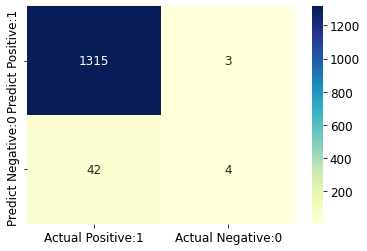

In [47]:
# Print the Confusion Matrix and slice it into four pieces
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

The confusion matrix shows 1315 + 4 = 1319 correct predictions and 3 + 42 = 45 incorrect predictions.

#### ROC

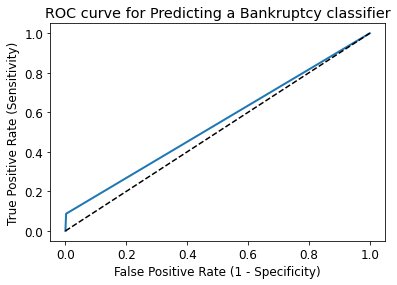

In [48]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a Bankruptcy classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC AUC

In [49]:
ROC_AUC = roc_auc_score(y_test, y_pred)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.5423


In [50]:
Cross_validated_ROC_AUC = cross_val_score(linear_svc100, X_train, y_train, cv=10, scoring='roc_auc').mean()
print('Cross validated ROC AUC : {:.4f}'.format(Cross_validated_ROC_AUC))

Cross validated ROC AUC : 0.8868


### Polynomial Kernal

In [51]:
# instantiate classifier with polynomial kernel and C=1.0
poly_svc=SVC(kernel='poly', C=1.0) 
# fit classifier to training set
poly_svc.fit(X_train,y_train)
# make predictions on test set
y_pred=poly_svc.predict(X_test)
# compute and print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1318
           1       0.60      0.13      0.21        46

    accuracy                           0.97      1364
   macro avg       0.79      0.56      0.60      1364
weighted avg       0.96      0.97      0.96      1364



#### Confusion Matrix

Confusion matrix

 [[1314    4]
 [  40    6]]

True Positives(TP) =  1314

True Negatives(TN) =  6

False Positives(FP) =  4

False Negatives(FN) =  40


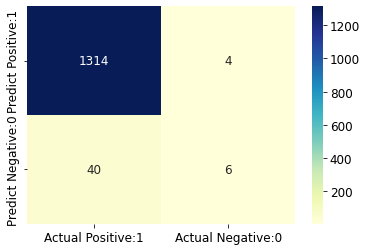

In [52]:
# Print the Confusion Matrix and slice it into four pieces
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

The confusion matrix shows 1314 + 6 = 1320 correct predictions and 4 + 40 = 44 incorrect predictions.

#### ROC

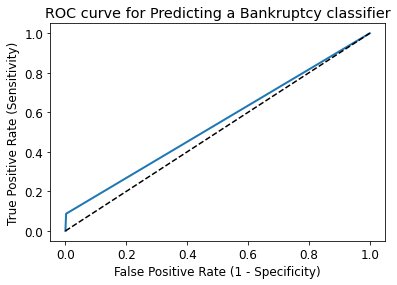

In [53]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a Bankruptcy classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC AUC

In [54]:
ROC_AUC = roc_auc_score(y_test, y_pred_test)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.5423


In [55]:
Cross_validated_ROC_AUC = cross_val_score(poly_svc, X_train, y_train, cv=10, scoring='roc_auc').mean()
print('Cross validated ROC AUC : {:.4f}'.format(Cross_validated_ROC_AUC))

Cross validated ROC AUC : 0.7939


### Polynomial Kernal and C=100

In [56]:
# instantiate classifier with polynomial kernel and C=100.0
poly_svc100=SVC(kernel='poly', C=100.0) 
# fit classifier to training set
poly_svc100.fit(X_train, y_train)
# make predictions on test set
y_pred=poly_svc100.predict(X_test)
# compute and print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1318
           1       0.34      0.28      0.31        46

    accuracy                           0.96      1364
   macro avg       0.66      0.63      0.64      1364
weighted avg       0.95      0.96      0.96      1364



#### Confusion Matrix

Confusion matrix

 [[1293   25]
 [  33   13]]

True Positives(TP) =  1293

True Negatives(TN) =  13

False Positives(FP) =  25

False Negatives(FN) =  33


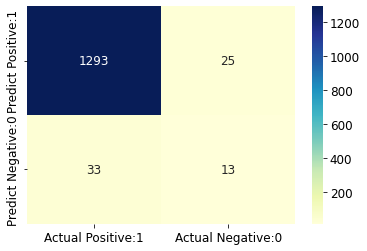

In [57]:
# Print the Confusion Matrix and slice it into four pieces
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

The confusion matrix shows 1293 + 13 = 1306 correct predictions and 25 + 33 = 58 incorrect predictions.

#### ROC

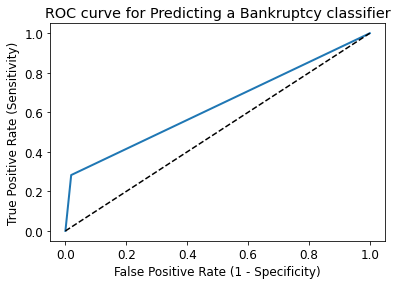

In [58]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a Bankruptcy classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC AUC

In [59]:
ROC_AUC = roc_auc_score(y_test, y_pred)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.6318


In [60]:
Cross_validated_ROC_AUC = cross_val_score(poly_svc100, X_train, y_train, cv=10, scoring='roc_auc').mean()
print('Cross validated ROC AUC : {:.4f}'.format(Cross_validated_ROC_AUC))

Cross validated ROC AUC : 0.7273


### Sigmoid Kernel

In [61]:
# instantiate classifier with sigmoid kernel and C=1.0
sigmoid_svc=SVC(kernel='sigmoid', C=1.0) 
# fit classifier to training set
sigmoid_svc.fit(X_train,y_train)
# make predictions on test set
y_pred=sigmoid_svc.predict(X_test)
# compute and print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1318
           1       0.36      0.22      0.27        46

    accuracy                           0.96      1364
   macro avg       0.67      0.60      0.62      1364
weighted avg       0.95      0.96      0.96      1364



#### Confusion Matrix

Confusion matrix

 [[1300   18]
 [  36   10]]

True Positives(TP) =  1300

True Negatives(TN) =  10

False Positives(FP) =  18

False Negatives(FN) =  36


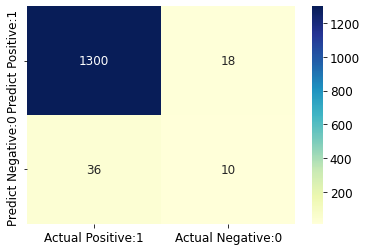

In [62]:
# Print the Confusion Matrix and slice it into four pieces
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

# visualize confusion matrix with seaborn heatmap
cm_matrix = pd.DataFrame(data=cm, columns=['Actual Positive:1', 'Actual Negative:0'], 
                                 index=['Predict Positive:1', 'Predict Negative:0'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

The confusion matrix shows 1300 + 10 = 1310 correct predictions and 18 + 36 = 54 incorrect predictions.

#### ROC

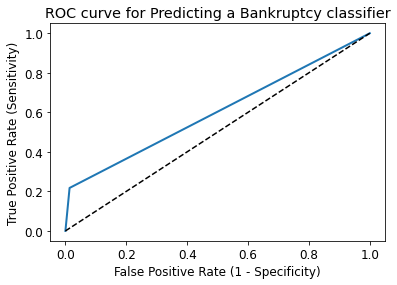

In [63]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a Bankruptcy classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

ROC AUC

In [64]:
ROC_AUC = roc_auc_score(y_test, y_pred)
print('ROC AUC : {:.4f}'.format(ROC_AUC))

ROC AUC : 0.6019


In [65]:
Cross_validated_ROC_AUC = cross_val_score(sigmoid_svc, X_train, y_train, cv=10, scoring='roc_auc').mean()
print('Cross validated ROC AUC : {:.4f}'.format(Cross_validated_ROC_AUC))

Cross validated ROC AUC : 0.7880


### Hyperparameter Optimization

Reference: https://www.geeksforgeeks.org/svm-hyperparameter-tuning-using-gridsearchcv-ml/

In [85]:
# defining parameter range
param_grid = [{'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']},
              {'C':[1, 10, 100, 1000], 
               'kernel':['poly'], 
               'degree': [2,3,4] ,
               'gamma':[0.01,0.02,0.03,0.04,0.05]},
              {'C':[1, 10, 100, 1000],
               'kernel':['linear']} ]
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train, y_train)

Fitting 5 folds for each of 89 candidates, totalling 445 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.969 total time=   3.4s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.968 total time=   2.6s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.968 total time=   2.5s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.968 total time=   2.5s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.968 total time=   2.5s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.969 total time=   1.1s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.968 total time=   1.1s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.968 total time=   1.1s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.968 total time=   1.1s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.968 total time=   1.1s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.969 total time=   0.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid=[{'C': [0.1, 1, 10, 100, 1000],
                          'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                          'kernel': ['rbf']},
                         {'C': [1, 10, 100, 1000], 'degree': [2, 3, 4],
                          'gamma': [0.01, 0.02, 0.03, 0.04, 0.05],
                          'kernel': ['poly']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['linear']}],
             verbose=3)

In [86]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
SVC(C=10, gamma=0.1)


In [87]:
grid_predictions = grid.predict(X_test)
 
# print classification report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1318
           1       0.25      0.07      0.10        46

    accuracy                           0.96      1364
   macro avg       0.61      0.53      0.54      1364
weighted avg       0.94      0.96      0.95      1364



## Logistic Regression

Logistic Regression accuracy is : 0.9648093841642229
----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1318
           1       0.44      0.15      0.23        46

    accuracy                           0.96      1364
   macro avg       0.70      0.57      0.60      1364
weighted avg       0.95      0.96      0.96      1364

Confusion matrix

 [[360 958]
 [  5  41]]

True Positives(TP) =  360

True Negatives(TN) =  41

False Positives(FP) =  958

False Negatives(FN) =  5


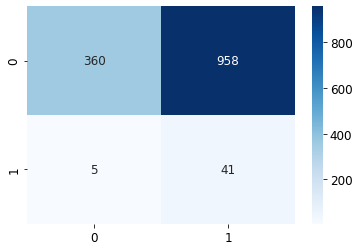

In [69]:
lr_model = LogisticRegression()
lr_model.fit(X_train,y_train)
accuracy_lr = lr_model.score(X_test,y_test)
print("Logistic Regression accuracy is :",accuracy_lr)
lr_pred= lr_model.predict(X_test)
print("-"*100)
print(classification_report(y_test,lr_pred))
cm = confusion_matrix(y_test,lr_model.predict(X_test))

# Print the Confusion Matrix and slice it into four pieces
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

# visualize confusion matrix with seaborn heatmap
sns.heatmap(cm,annot=True,fmt="d",cmap = "Blues")

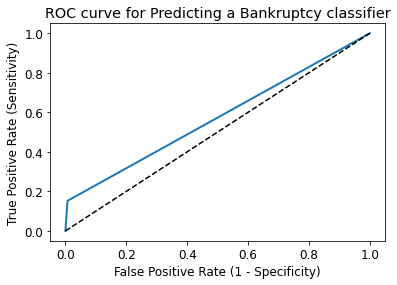

In [71]:
fpr, tpr, thresholds = roc_curve(y_test, lr_pred)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a Bankruptcy classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

### Hyperparameter Optimization using GridSearch CV

In [74]:
parameters = {"class_weight": ["None", "balanced"], 
              "max_iter": [25,50,75,100],
              "penalty": ["l1", "l2", "elasticnet", "none"], 
              "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
             }

In [76]:
grid_cv = GridSearchCV(lr_model, parameters, scoring = make_scorer(accuracy_score))
grid_cv = grid_cv.fit(X_train, y_train)

In [77]:
print("Our optimized Logistic Regression model is:")
grid_cv.best_estimator_

Our optimized Logistic Regression model is:


LogisticRegression(class_weight='None', penalty='none', solver='sag')

Build a better Logistic Regression Model

In [79]:
logreg_clf_GSCV = LogisticRegression(class_weight='None', penalty='none', solver='sag')
logreg_clf_GSCV.fit(X_train, y_train)
logreg_GSCV_pred = logreg_clf_GSCV.predict(X_test)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1318
           1       0.64      0.15      0.25        46

    accuracy                           0.97      1364
   macro avg       0.80      0.57      0.61      1364
weighted avg       0.96      0.97      0.96      1364

Confusion matrix

 [[360 958]
 [  5  41]]

True Positives(TP) =  360

True Negatives(TN) =  41

False Positives(FP) =  958

False Negatives(FN) =  5


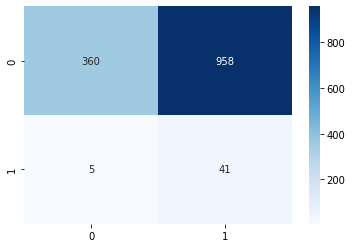

In [80]:
print(classification_report(y_test, logreg_GSCV_pred))
cm = confusion_matrix(y_test, logreg_clf_GSCV.predict(X_test))

# Print the Confusion Matrix and slice it into four pieces
cm = confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n', cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

# visualize confusion matrix with seaborn heatmap
sns.heatmap(cm,annot=True,fmt="d",cmap = "Blues")

The confusion matrix shows 360 + 41 = 401 correct predictions and 958 + 5 =1003 incorrect predictions.

...I actually think it's not a better model...

## Naive Bayes

confusion matrix:
 [[360 958]
 [  5  41]]
accuracy score =  0.2939882697947214
Report:               precision    recall  f1-score   support

           0       0.99      0.27      0.43      1318
           1       0.04      0.89      0.08        46

    accuracy                           0.29      1364
   macro avg       0.51      0.58      0.25      1364
weighted avg       0.95      0.29      0.42      1364



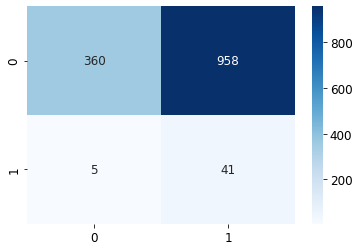

In [67]:
nb = GaussianNB()
nb.fit(X_train,y_train)

y_pred = nb.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
print('confusion matrix:\n',cm)

nba = accuracy_score(y_test,y_pred)
print('accuracy score = ', accuracy_score(y_test,y_pred))
print("Report:", classification_report(y_test,y_pred))

sns.heatmap(cm,annot=True,fmt="d",cmap = "Blues")

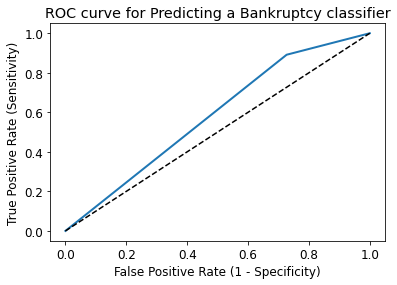

In [68]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, linewidth=2)

plt.plot([0,1], [0,1], 'k--' )
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a Bankruptcy classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.show()

# Conclusion

Without any features selection or outlier removal, SMV with Polynomial Kernal performed the best with a 97% F1 score, but honestly, Logistic Regression was not far behind. Naive Bayes, as usual, performed poorly. This is probably due to the massive amounts of noise in this dataset. If this were real life, I would try to collect more samples of this data so the dataset wasn't so imbalanced.